In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [5]:
prep = pd.read_csv('/content/data.csv')

In [6]:
prep.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [7]:
prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [8]:
prep.isnull().sum()

,0
record_ID,0
week,0
store_id,0
sku_id,0
total_price,1
base_price,0
is_featured_sku,0
is_display_sku,0
units_sold,0


In [11]:
from sklearn.impute import SimpleImputer

In [12]:
numerical_fields = prep.select_dtypes(include=[np.number]).columns.tolist()
categorical_fields = prep.select_dtypes(include=['object']).columns.tolist()

imputer = SimpleImputer(strategy="mean")
prep[numerical_fields] = imputer.fit_transform(prep[numerical_fields])

for col in categorical_fields:
    prep[col].fillna(prep[col].mode()[0], inplace=True)

print("Missing values imputed!")


Missing values imputed!


<ipython-input-12-20e99ed8243e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prep[col].fillna(prep[col].mode()[0], inplace=True)


In [13]:
prep['key'] = prep['week'].astype(str) + '_' + prep['store_id'].astype(str)

In [14]:
prep = prep.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price',
                  'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)
print("Dropped unnecessary columns.")

Dropped unnecessary columns.


Grouped by 'key'.


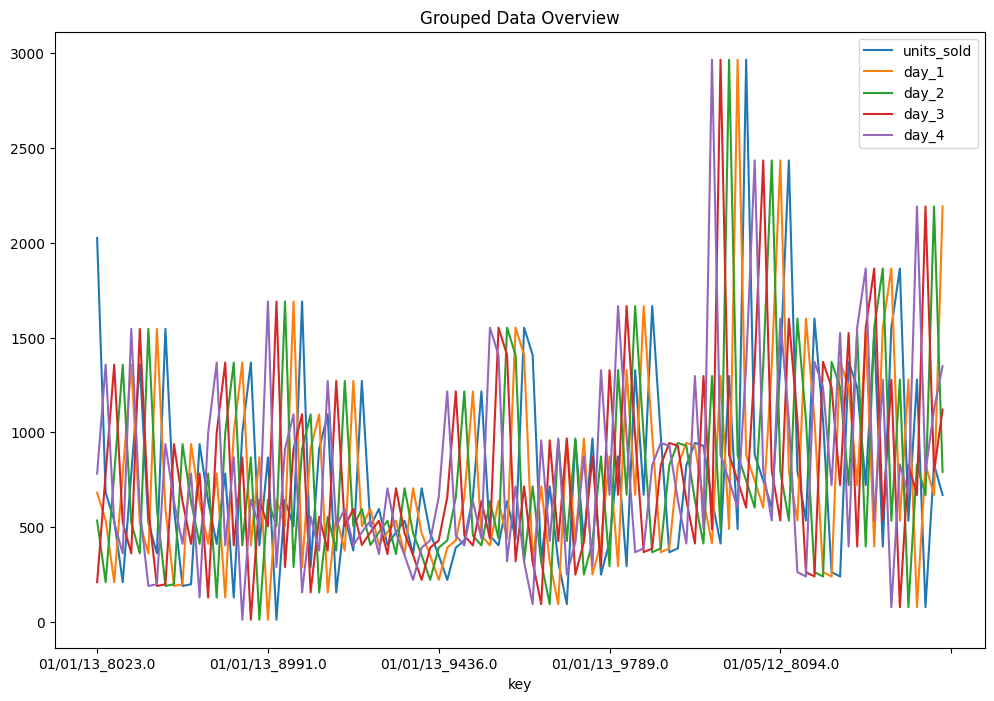

In [20]:
prep = prep.groupby('key').sum()
print("Grouped by 'key'.")

prep[:100].plot(figsize=(12, 8))
plt.title("Grouped Data Overview")
plt.show()

Lag features created and missing values removed.


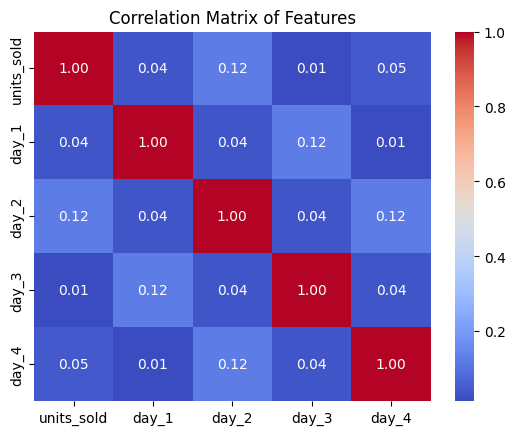

In [19]:
prep['day_1'] = prep['units_sold'].shift(-1)
prep['day_2'] = prep['units_sold'].shift(-2)
prep['day_3'] = prep['units_sold'].shift(-3)
prep['day_4'] = prep['units_sold'].shift(-4)

prep = prep.dropna()
print("Lag features created and missing values removed.")

sns.heatmap(prep.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

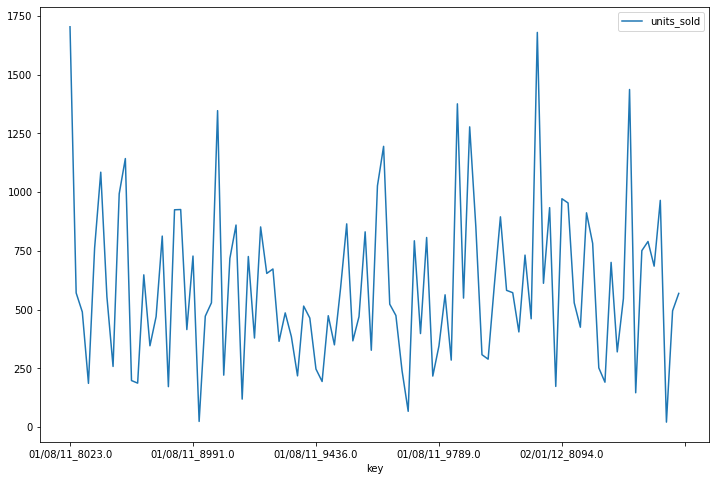

In [ ]:
prep.df[:100].plot(figsize=(12,8))

In [23]:
x1, x2, x3, x4, y =prep['day_1'],prep['day_2'],prep['day_3'],prep['day_4'],prep['units_sold']
x1, x2, x3, x4, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(y)
x1, x2, x3, x4, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(prep)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

# Random Forest Regression

In [24]:
# Calculate mean and variance of target (y) for each feature
feature_stats = []
for feature_idx in range(X_train.shape[1]):
    feature_col = X_train[:, feature_idx]
    stats = {
        "mean": np.mean(y_train.flatten()[feature_col.argsort()]),
        "variance": np.var(y_train.flatten()[feature_col.argsort()])
    }
    feature_stats.append(stats)

print("Feature statistics calculated for Gaussian distribution.")


Feature statistics calculated for Gaussian distribution.


In [25]:
def gaussian_pdf(x, mean, variance):
    """Calculate the probability density function for Gaussian distribution."""
    exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
    return (1 / np.sqrt(2 * np.pi * variance)) * exponent


In [26]:
def naive_bayes_predict(X, feature_stats):
    """Predict target using Naive Bayes Regression."""
    predictions = []
    for row in X:
        # Calculate probability for each feature
        probabilities = []
        for feature_idx, feature_val in enumerate(row):
            mean = feature_stats[feature_idx]["mean"]
            variance = feature_stats[feature_idx]["variance"]
            probabilities.append(gaussian_pdf(feature_val, mean, variance))

        # Combine probabilities (Naive Bayes assumes independence)
        combined_probability = np.product(probabilities)
        predictions.append(combined_probability)
    return np.array(predictions)


In [27]:
# Predict on test data
y_pred_nb = naive_bayes_predict(X_test, feature_stats)
print("Predictions made using Naive Bayes Regression.")


Predictions made using Naive Bayes Regression.


<ipython-input-27-862f4dc99493>:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_pred_nb = naive_bayes_predict(X_test, feature_stats)


In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred_nb)
r2_score = 1 - (mse / np.var(y_test))

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2_score}")


Mean Squared Error (MSE): 786029.2777027027
R^2 Score: -2.7389326409469574


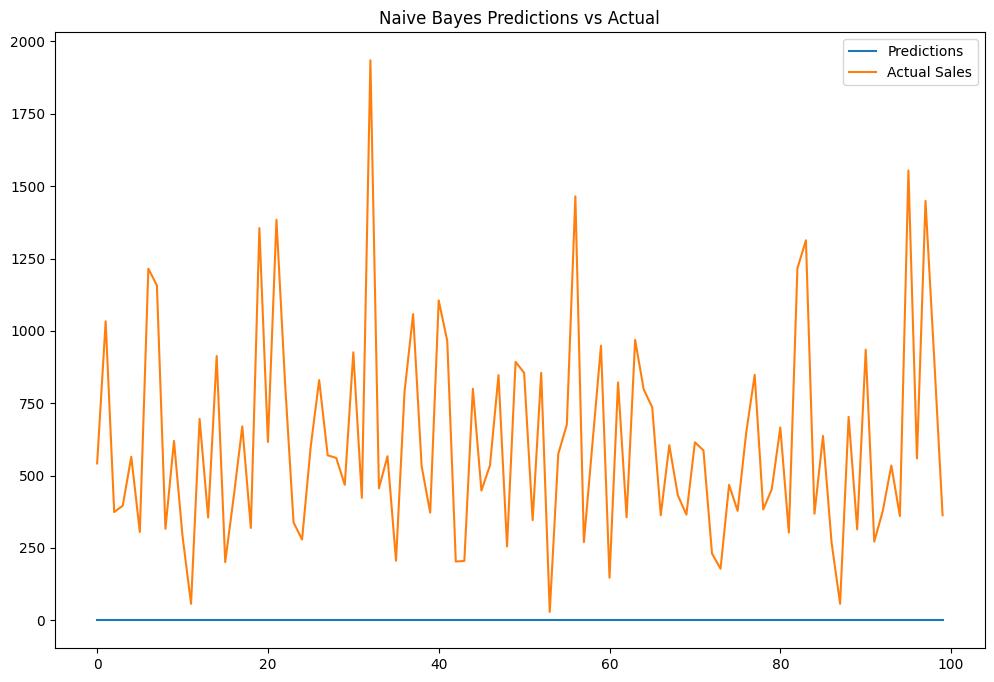

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(y_pred_nb[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.title("Naive Bayes Predictions vs Actual")
plt.legend()
plt.show()


XGBoost Regression model trained successfully!
XGBoost Regression - Mean Squared Error (MSE): 141829.73492357292
XGBoost Regression - R^2 Score: 0.3253535963539872


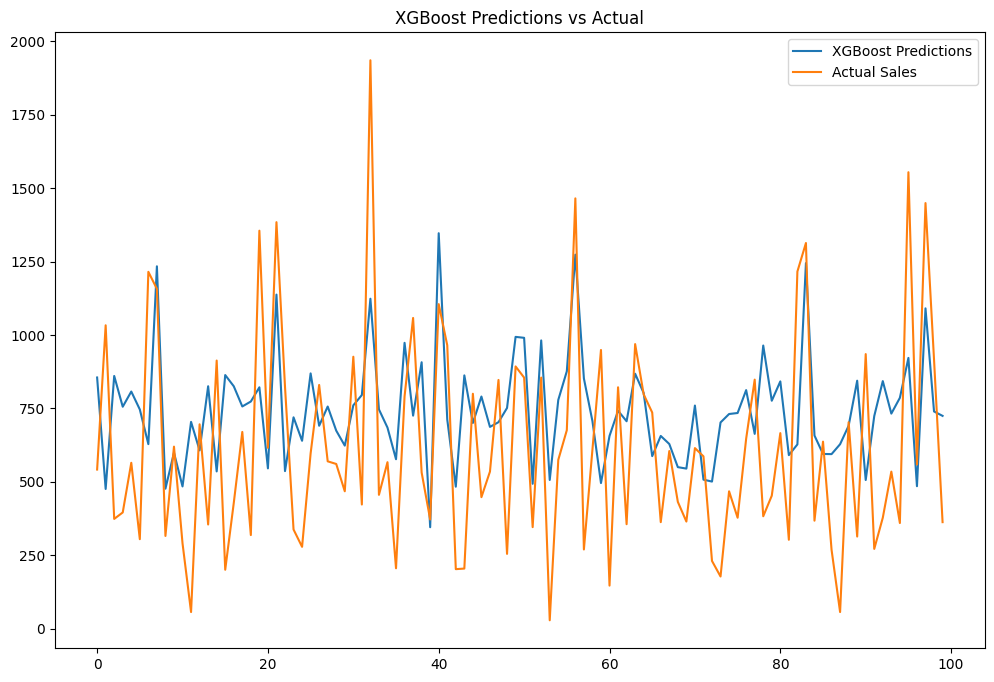

In [37]:
import xgboost
from xgboost import XGBRegressor
# Initialize and train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Reproducibility
)

xgb_model.fit(X_train, y_train.ravel())
print("XGBoost Regression model trained successfully!")

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = 1 - (mse_xgb / np.var(y_test))

print(f"XGBoost Regression - Mean Squared Error (MSE): {mse_xgb}")
print(f"XGBoost Regression - R^2 Score: {r2_xgb}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 8))
plt.plot(y_pred_xgb[-100:], label='XGBoost Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.title("XGBoost Predictions vs Actual")
plt.legend()
plt.show()


Model Comparison:
Naive Bayes - Mean Squared Error: 786029.2777027027
Naive Bayes - R^2 Score: -2.7389326409469574
XGBoost - Mean Squared Error: 141829.73492357292
XGBoost - R^2 Score: 0.3253535963539872


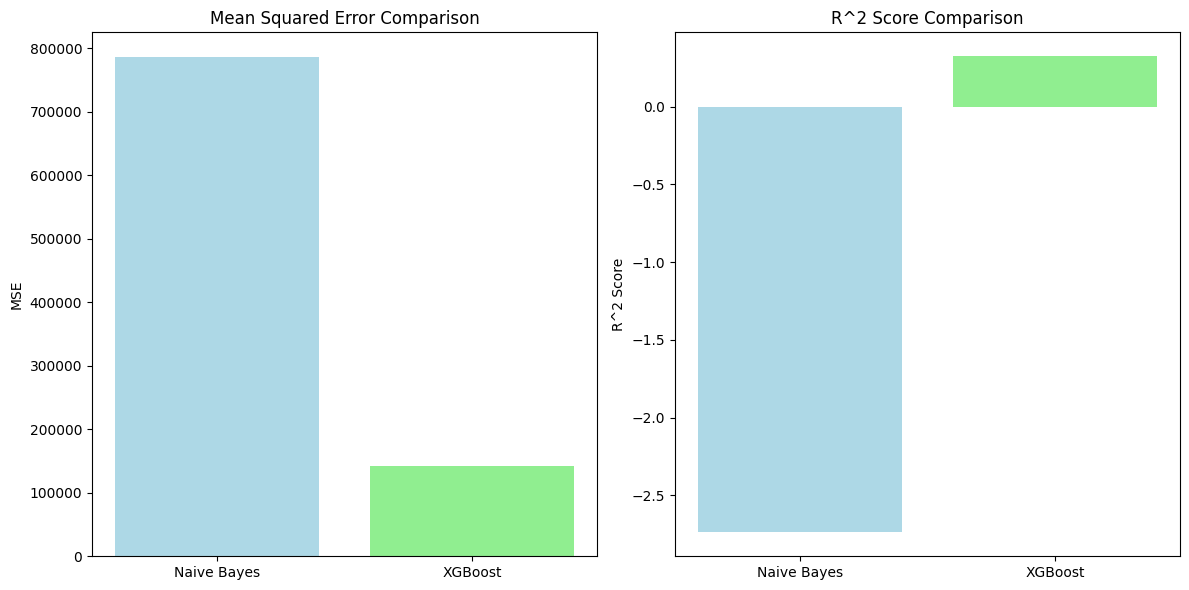

In [34]:
print("R Sq. Score for XGBoost :", xgb_regressor.score(X_test, y_test))

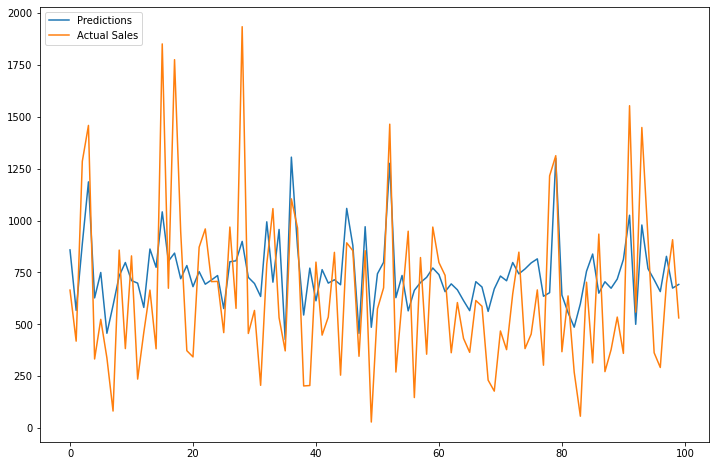

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# Hyperparameter Tuning for Random Forest

In [42]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [44]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [45]:
rf_random.best_params_

{'n_estimators': 116,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 31,
 'bootstrap': True}

In [46]:
best_random = rf_random.best_estimator_

In [47]:
y_pred = best_random.predict(X_test)

In [48]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print("Adj. R Sq. Score for Random Forest Regression :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R Sq. Score for Random Forest Regression : 0.6651078523191962
Adj. R Sq. Score for Random Forest Regression : 0.6641996702237907


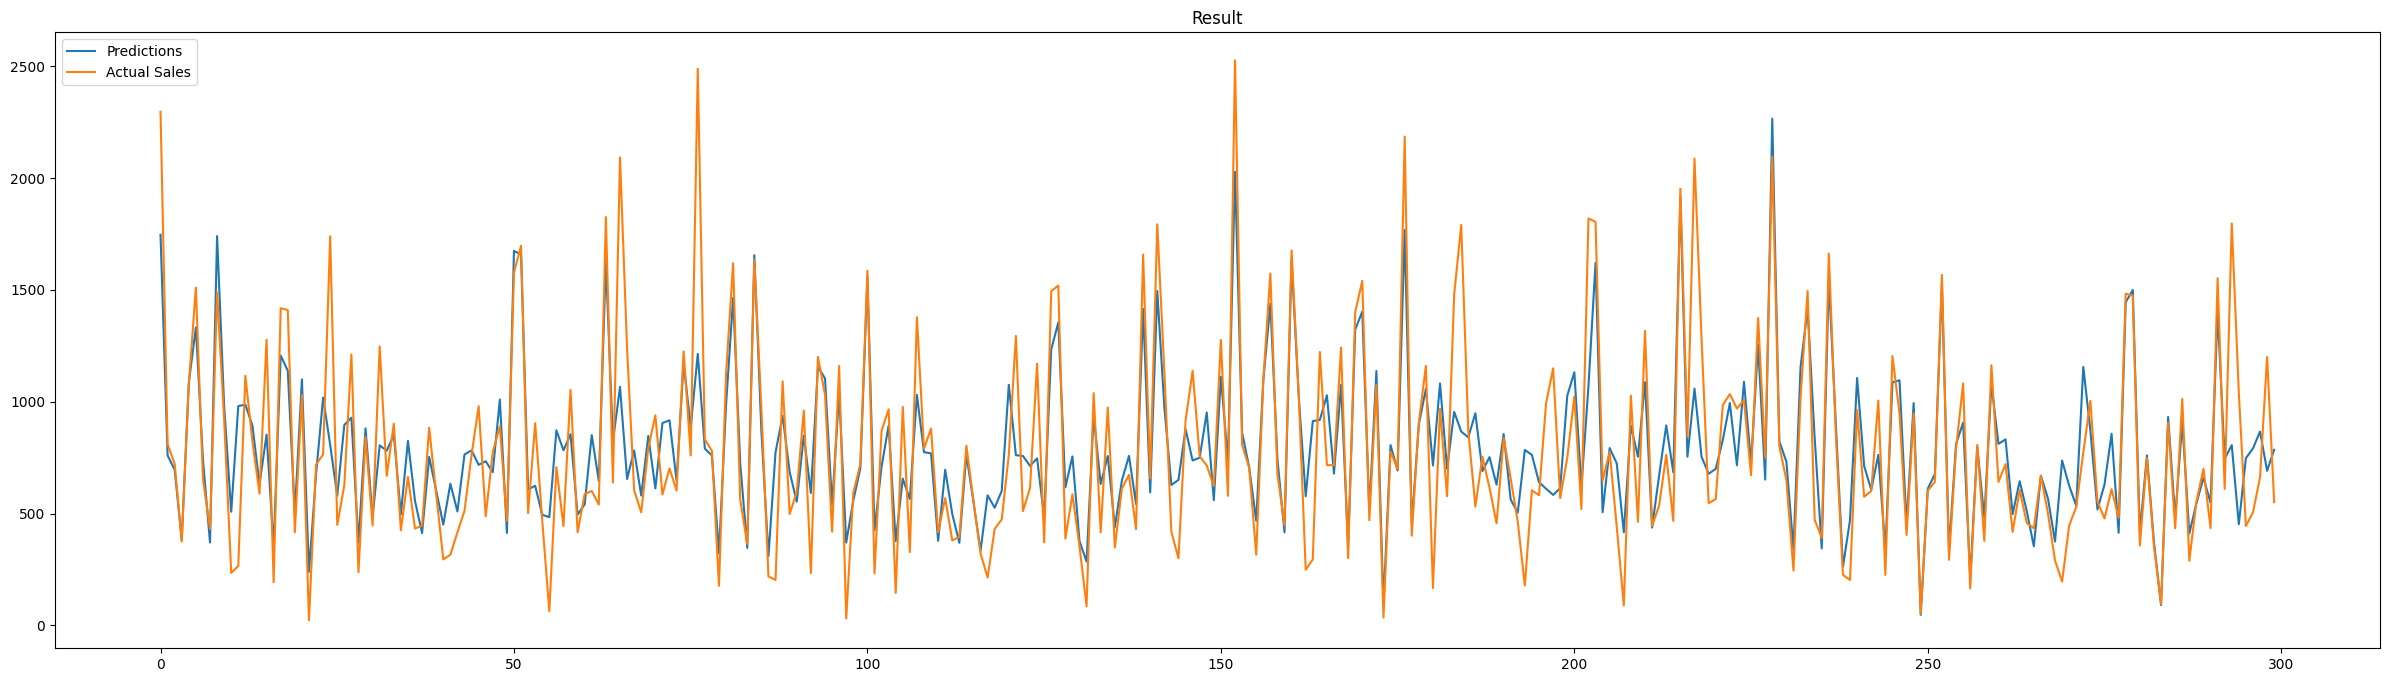

In [49]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.title("Result")
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()